In [12]:
%matplotlib inline
import matplotlib.collections
import matplotlib.colors
import matplotlib.pyplot as plt
import numpy
import operator
import pandas as pd
import plotly.io as pio
import plotly.graph_objects as go
import plotly.offline as py
import scipy
import scipy.linalg as linalg
import sympy as sp
import time
import timeit
import warnings
from scipy.optimize import curve_fit
from functools import reduce
from IPython.display import Image, display
from sympy.solvers import solve
pio.renderers.default = "notebook_connected"
py.offline.init_notebook_mode()

## **The Centered Difference Method vs. the Chebyshev Spectral Method: Convergence and Computation Time Analysis**

**Author:** Kyra Cho

**Note:** The interactive version can be found at https://kyracho.github.io/content/interactive_chebyshev_vs_finite_difference.html.

**Goal:** The goal of this write-up is to compare two numerical methods for solving differential equations. Although they achieve similar goals, their approaches, accuracy, and applications differ significantly. The comparisons will be based on their convergence behaviors and computation time behaviors. 

**Intended audience:** This write-up is intended for people with an undergraduate level of understanding of numerical methods.
 
* **The Chebyshev Spectral Method:**
    * Highly accurate and perfect for dealing with smooth solutions over simple domains.
    * Particularly useful for problems where the solution can be represented well by global polynomials.
    * Exponential convergence for smooth problems, meaning the error decreases exponentially as the mesh density increases.
    * Uses uneven grid points.
    * Applications include computational fluid dynamics, quantum mechanics, and meteorology.
    * Computational Cost: While fewer points are needed for a given accuracy, the global nature of the method leads to higher computational costs.
<br><br>
* **The Centered Difference Method:**
    *  Simple, easy to implement, and has applicability to a wide range of problems.
    *  Epecially suitable for problems where the solution may not be smooth or where the domain has complex geometry.
    *  Uses local information (neighboring points) to approximate the derivative at a given point.
    *  Second-Order Accuracy: The centered difference method has a truncation error of $O(\Delta x^2)$
    *  Commonly used for various types of differential equations, including those with non-smooth solutions or complex geometries.
    *  Engineering and Physics: Commonly used in engineering, physics, and other applied sciences for problems.
    *  More computationally efficient when high precision is not critical.


<br><br>
### **The Poisson's equation:**

We will solve a one-dimensional version of Poisson's equation over the domain $[-1,1]$ with the boundary condition $u(-1)=u(1)=0$. 

$$u''(x)= 100\,a \sin(a\, x).$$

The equation can be directly integrated twice to obtain the general solution. Informally, 

$$\begin{align*} u(x)=& \int\int f(x)\,dx^2\\
=& \int (-100\cos(a\,x)+c_1) \,dx\\
=& -\frac{100}{a}\sin(a\,x)+c_1x+c_2.\end{align*}$$

$c_1$ and $c_2$ are constants determined by the boundary conditions. Heuristically, the constants 'fit' the general solution to the specific problem perfectly. For our boundary conditions $u(-1)=u(1)=0$, 

$$u(x)=-\frac{100}{a}\sin(a\,x)+\frac{100}{a}\sin(a)\, x.$$

$u(x)$ will serve as the testing standard for the two methods. 

<br><br>
### **The Finite Difference Method**
The algebraic expression for the approximated solution is 

$$\frac{1}{\Delta x^2} (U_{i+1} - 2\, U_i + U_{i-1}) = f(x_i) \quad i = 1, 2, 3, \ldots, m,$$

where $\Delta x$ is the chosen mesh size and $m+2$ is the number of mesh points.

$U_i$ is solved as a system of equations:

$$\frac{1}{\Delta x^2} \begin{bmatrix}
    -2 &  1 &    &    &    \\
     1 & -2 &  1 &    &    \\
       &  1 & -2 &  1 &    \\
       &    &  1 & -2 &  1 \\
       &    &    &  1 & -2 \\
    \end{bmatrix} \begin{bmatrix}
        U_1 \\ U_2 \\ U_3 \\ U_4 \\ U_5
    \end{bmatrix} = 
    \begin{bmatrix}
        f(x_1) - \frac{\alpha}{\Delta x^2} \\ f(x_2) \\ f(x_3) \\ f(x_4) \\ f(x_5) - \frac{\beta}{\Delta x^2} \\
    \end{bmatrix}.$$


In [13]:
# define the function to compute the second order centered difference approximation solution to the Poisson equation
def centered_difference(a,b,m,f):
    ''' Solves the Poisson equation with zero boundary conditions given a function $f$. 
    Inputs 
        a: float. left boundary point
        b: float. right boundary point
        m: integer. determines the number of grid points on which to approximate U
        f: function. the right hand side of the function
    Outputs
        U: the solution evaluated on the grid points
    '''
    x_bc = numpy.linspace(a, b, m + 2)
    x = x_bc[1:-1]
    delta_x = (b - a) / (m + 1)

    # Construct matrix A
    A = numpy.zeros((m, m))
    diagonal = numpy.ones(m) / delta_x**2
    A += numpy.diag(diagonal * -2.0, 0)
    A += numpy.diag(diagonal[:-1], 1)
    A += numpy.diag(diagonal[:-1], -1)

    # Construct RHS
    b = f(x)
    b[0] -= u_a / delta_x**2
    b[-1] -= u_b / delta_x**2

    # Solve system
    U = numpy.empty(m + 2)
    U[0] = u_a
    U[-1] = u_b
    U[1:-1] = numpy.linalg.solve(A, b)
    
    return U

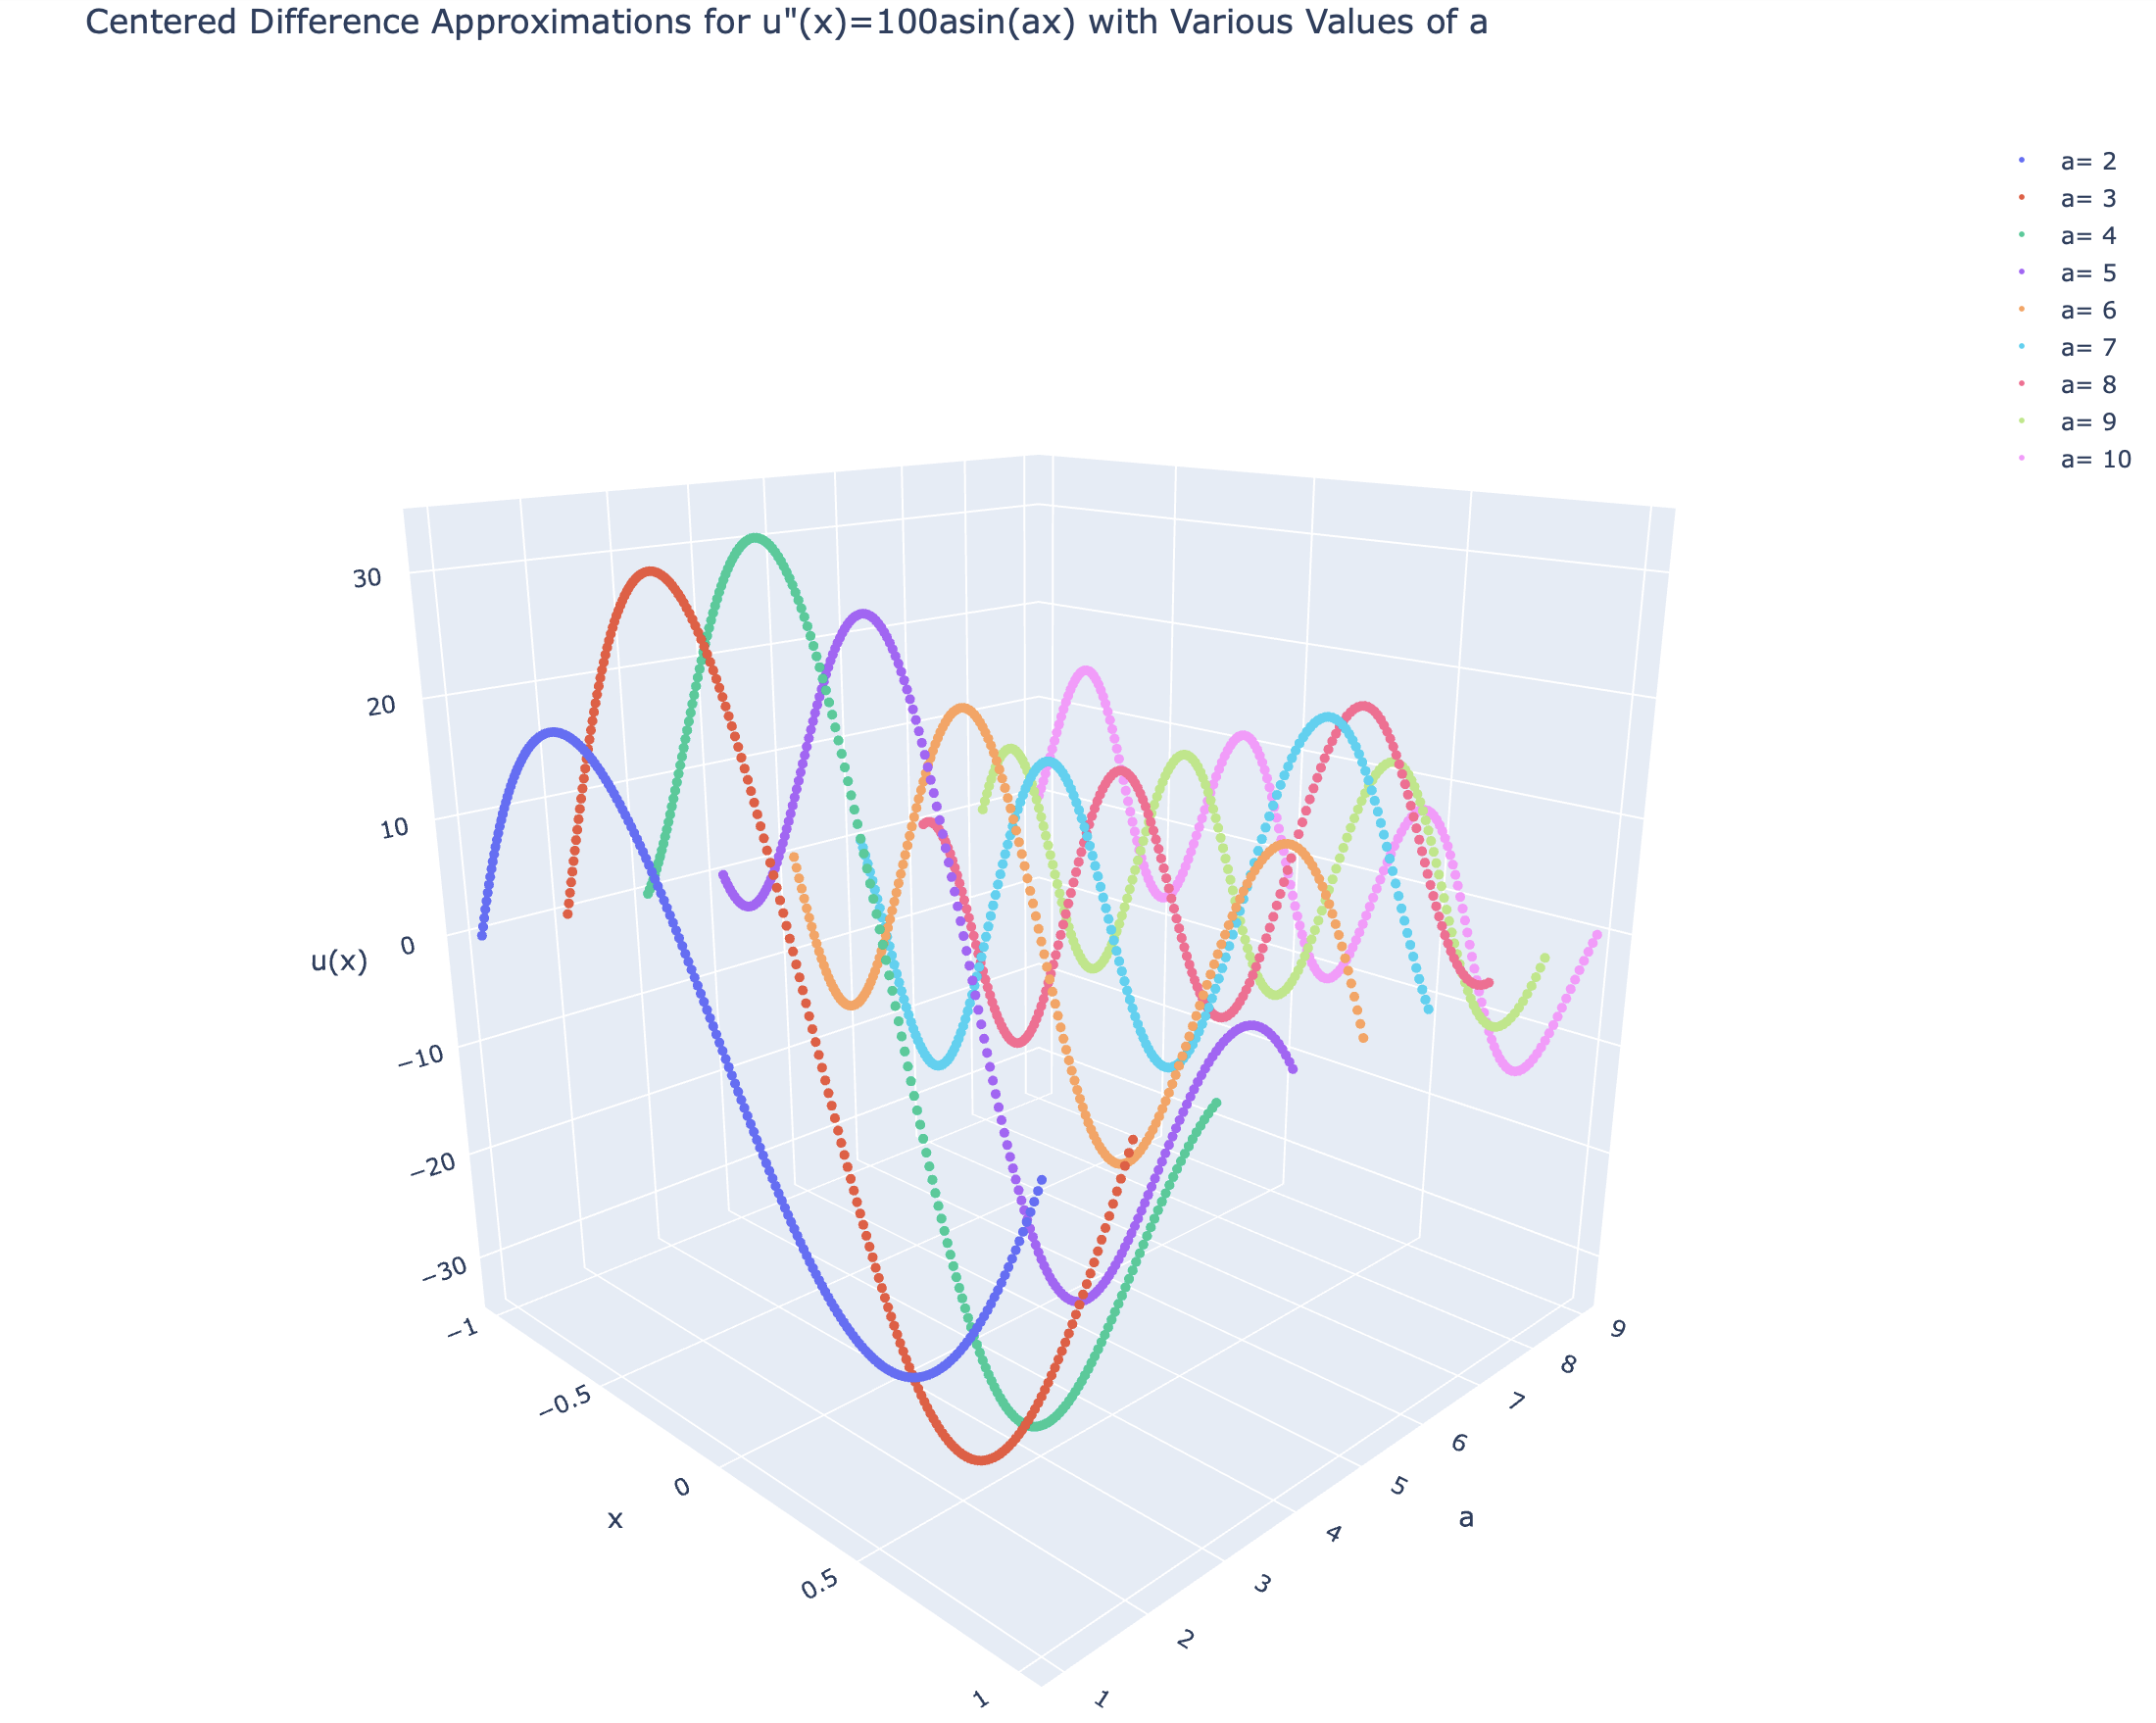

In [14]:
# graph the finite difference method
# initialize the problem 
a = -1
b = 1.0
u_a = 0.0
u_b = 0
m = 200
x_bc = numpy.linspace(a, b, m + 2)

# define the functions for graphing 
functions = [lambda x, n=n: (n + 1) * 100 * numpy.sin((n + 1) * x) for n in range(10)]
    
# graph only the centered difference solutions 
traces = []
for i in range(1,10):
    x_values = x_bc
    y_values = my_list = [i for _ in range(len(x_bc))]
    z_values = centered_difference(a,b,m,functions[i])
    traces.append(go.Scatter3d(
        x=x_values,
        y=y_values,
        z=z_values,
        mode='markers',
        marker=dict(
            size = 3
        ),
        name=f'a= {i+1}'
    ))

layout = go.Layout(
    title_text=r'Centered Difference Approximations for u"(x)=100asin(ax) with Various Values of a',
    scene=dict(
        xaxis_title='x',
        yaxis_title='a',
        zaxis_title='u(x)',
        camera=dict(
            eye=dict(x=1.5, y=-1.5, z=1.25)   
        )
    ),
    height=1000,
    width=None 
)

# set the responsive attribute
config = {
    'responsive': True
}

fig = go.Figure(data=traces, layout=layout)
#fig.show()
display(Image(filename='Chebyshev_vs_Finite_Difference_pics/1.png'))

*Figure 1: Centered difference approximations to $u''(x)=100a\sin(ax)$ with various values of $a$.*

**Analysis of figure 1:** This is an interactive plot displaying the centered difference approximations to $u"(x)=100a\sin(ax)$ with various values of $a$. The $x$-axis represents the grid points in $[-1,1]$, the $a$-axis represents the various values of $a$, and the $u(x)$-axis represents the solution space. The colored orbs represent the approximate solutions. Each approximation is evaluated using $202$ equidistant mesh points. 


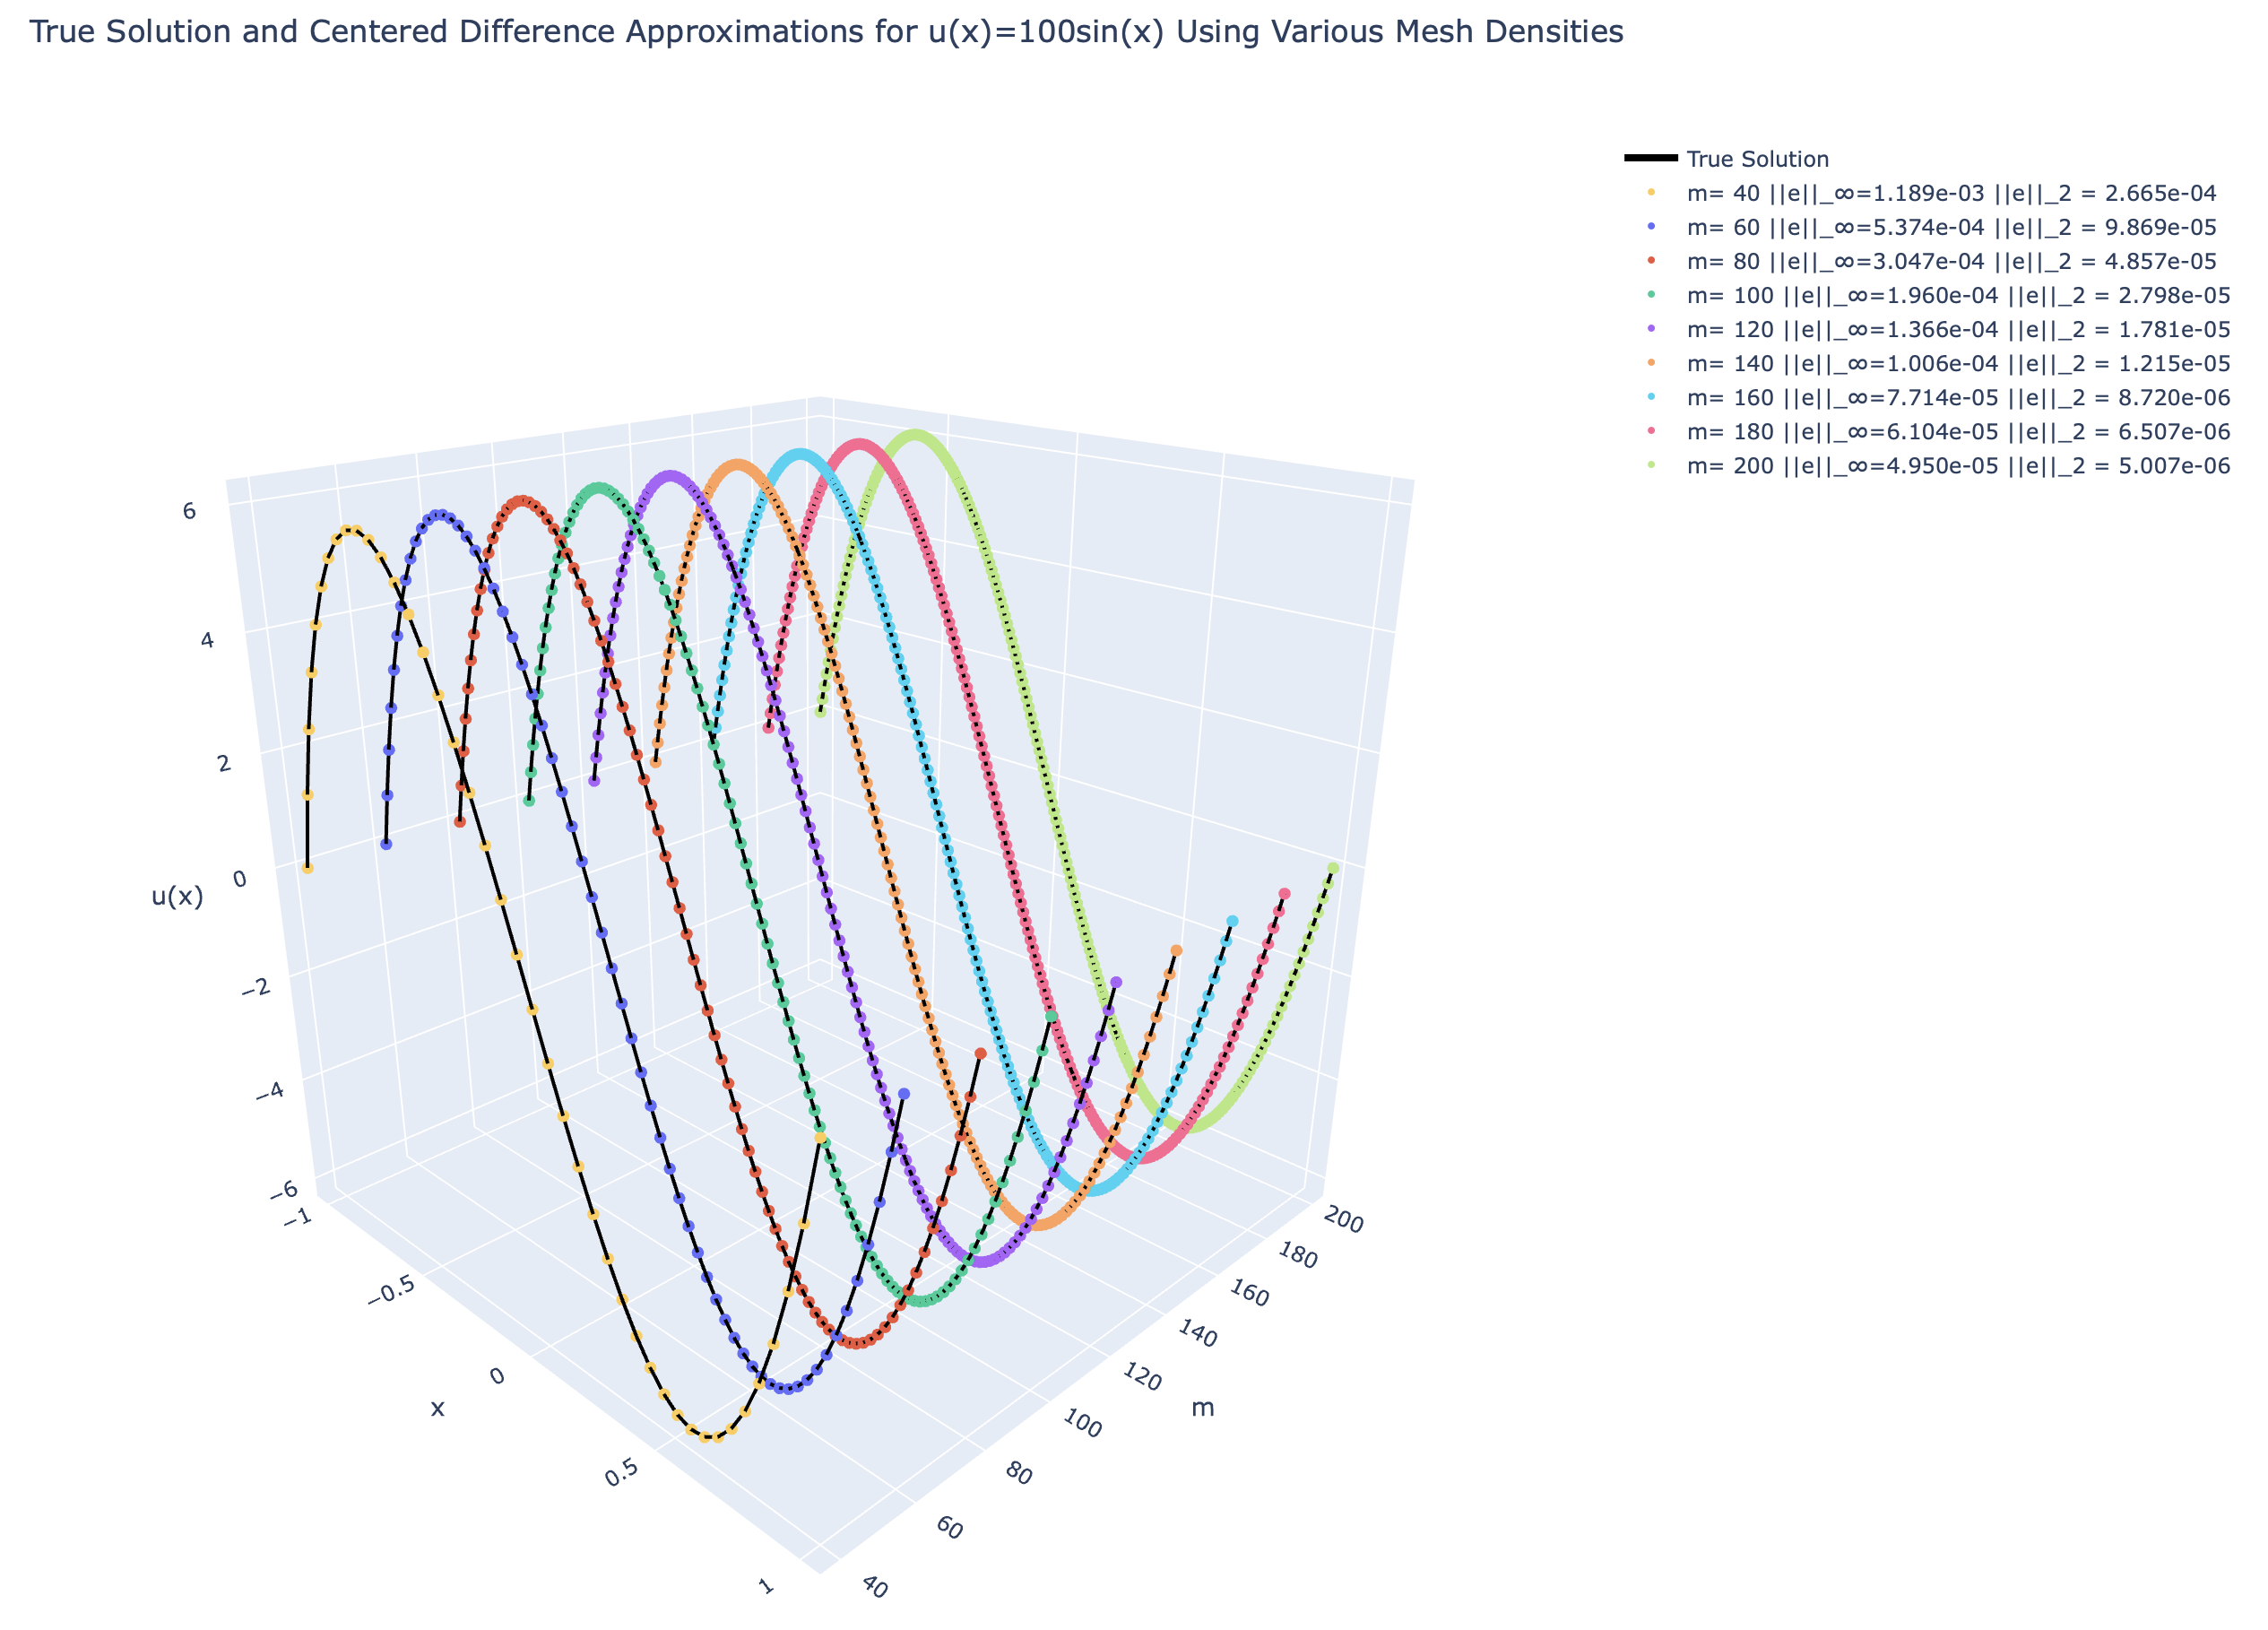

In [15]:
# choose a function for convergence analysis
f = lambda x: 100 * numpy.sin(x)

# define the true solution for comparison
def u_true(x):
    '''this function returns the most accurate solution to the Poisson equation possible'''
    f = lambda x: -100 * numpy.sin(x) + 100* numpy.sin(1)*x
    return f(x)

# define the list of various meshes for centered difference
m = [20 * i for i in range(1, 11)]

# compute the global abd infinity norm errors
error = []
error2 = []
for i in m:
    U = centered_difference(a,b,i,f)
    x_bc = numpy.linspace(a, b, i + 2)
    u = u_true(x_bc)
    u = u.astype(float)
    error.append(numpy.linalg.norm(U - u, ord=numpy.infty))
    
    # compute the global error
    delta_x = x_bc[1] - x_bc[0]
    error2.append(delta_x * numpy.linalg.norm(U - u, ord=2))

# graph the approximate and true solutions 

# the true solutions
traces = []
for i in range(1,10):
    x_bc = numpy.linspace(a, b, m[i] + 2)
    x_values = x_bc
    y_values =  mylist = [(i+1)*20 for _ in range(len(x_bc))]
    z_values = u_true(x_bc)
    trace_name = 'True Solution' if i == 1 else ''
    show_legend = True if i == 1 else False
    traces.append(go.Scatter3d(
        x=x_values,
        y=y_values,
        z=z_values,
        mode='lines',
        line=dict(
            width=4,
            color = 'black' 
        ),
        name=trace_name,
        showlegend=show_legend
    ))

# the approximate solutions 
for i in range(1,10):
    x_bc = numpy.linspace(a, b, m[i] + 2)
    x_values = x_bc
    y_values = [(i+1)*20 for _ in range(len(x_bc))]
    z_values = centered_difference(a,b,m[i],f)
    traces.append(go.Scatter3d(
        x=x_values,
        y=y_values,
        z=z_values,
        mode='markers',
        marker=dict(
            size = 4
        ),
        name=f'm= {m[i]} ||e||_∞={"{:.3e}".format(error[i])} ||e||_2 = {"{:.3e}".format(error2[i])}'
    ))

# Create the layout
layout = go.Layout(
    title='True Solution and Centered Difference Approximations for u''(x)=100sin(x) Using Various Mesh Densities',
    scene=dict(
        xaxis_title='x',
        yaxis_title='m',
        zaxis_title='u(x)',
        camera=dict(
            eye=dict(x=2.2, y=-2.2, z=1.3) 
        )
    ),
    height=1000,
    width=None 
)

# Set the responsive attribute
config = {
    'responsive': True
}
# Create the figure and plot it
fig = go.Figure(data=traces, layout=layout)
#fig.show()
display(Image(filename='Chebyshev_vs_Finite_Difference_pics/2.png'))

*Figure 2: Centered difference approximations to $u''(x)=100\sin(x)$ with various mesh densities.*

**Analysis of figure 2:** This is an interactive plot displaying the centered difference approximations to $\frac{d^2}{dx^2}u(x)=100\sin(x)$ with various mesh densities. The $x$-axis represents the grid points in $[-1,1]$, the $m$-axis represents the various values of $m$, and the $u(x)$-axis represents the solution space. The colored orbs represent the approximate solutions and the black lines represent the true solution. We can see that the global and maximum errors decrease when $m$ increases. 


<br><br>

### **The Chebyshev Spectral Method**

The Chebyshev method approximates the solution using interpolation points that are distributed as

$$x_j = \cos\left(\frac{j \pi}{N} \right), \quad j=0, 1, \ldots, N.$$

These points are called the Chebyshev points of the second kind. The finite differences method is derived by interpolating a polynomial through the stencil points and taking the derivative of the resulting interpolant. Let 

$$p_N(x_j) = v_j, \quad 0 \leq j \leq N$$

be the polynomial of degree $N$, then the resulting derivative is

$$p'_N(x_j) = w_j.$$

Since this operation is linear we can form this as multiplication by a matrix:

$$\mathbf{w} = \mathbf{D}_N \mathbf{v}.$$

In general the Chebyshev differentiation matrices take the form

$$\begin{aligned}
    (D_N)_{00} = \frac{2 N^2 + 1}{6}, & & (D_N)_{NN} = -\frac{2N^2 + 1}{6}, \\
    (D_N)_{jj} = \frac{-x_j}{2(1 - x_j^2)}, & & j=1,\ldots,N-1 \\
    (D_N)_{ij} = \frac{c_i(-1)^{i+j}}{c_j (x_i - x_j)}, & & i\neq j, ~~ i,j = 0, \ldots, N
\end{aligned}$$

where 

$$c_i = \begin{cases}
        2 & & i=0 \text{ or } N \\
        1 & & \text{otherwise}.
    \end{cases}$$

The second derivative is computed using this matrix $D$, by operating iteratively on $U$ twice.

$$D^2_N U \approx \frac{d^2}{dx^2}u(x_i).$$

This lets us solve Poisson's equation, as a set of equations for the $U_i$s approximated at the Chebyshev nodes $x_i.$

$$\begin{align*}&D^2_N U = F \\
\Longrightarrow \,\, &U = (D^2_N)^{-1}F.\end{align*}$$
 
 
 

In [16]:
# define the functions to compute the approximated solutions to the Poisson equation using Chebyshev polynomials
warnings.filterwarnings('ignore')

def cheb(N):
    '''Takes as input an integer N and returns a set of Chebyshev nodes on the domain -1<x<1
    and the Chebyshev differentiatoin matrix for computing the second derivative of U
        Inputs
            N : the number of Chebyshev nodes 
        Outputs
            D : the Chebyshev differentiation matrix with N+1 rows and columns
            x : the Chebychev nodes
    '''
    x = numpy.cos(numpy.pi * numpy.arange(N+1) / N)
    e = numpy.ones((N + 1, 1))
    Xdiff = numpy.outer(x, e) - numpy.outer(e, x) + numpy.identity(N + 1)
    xprod = -reduce(operator.mul, Xdiff) # product of rows
    W = numpy.outer(1.0 / xprod, e)
    D = W / numpy.multiply(W.T, Xdiff)
    d = 1-sum(D)

    for k in range(0, N+1):  # Set diagonal elements
        D[k,k] = d[k]

    return -D.T, x

def cheb_poisson(N,f):
    ''' calls the function cheb and computes the solution to the Poisson boundary value problem given the function f.
        Inputs
            N: the number of Chebyshev nodes to interpolate the solution 
            f: the right side function of the Poisson equation 
        Outputs
            x: the N+1 Chebyshev nodes 
            U: the approximated solution to the Poisson equation on N+1 points
    '''
    # compute square and remove boundaries
    D, x = cheb(N)
    D2 = numpy.dot(D, D)[1:-1, 1:-1]

    # solve the problem
    U = numpy.zeros(N + 1)
    U[1:-1] = numpy.linalg.solve(D2, f(x[1:-1]))
    
    return x, U

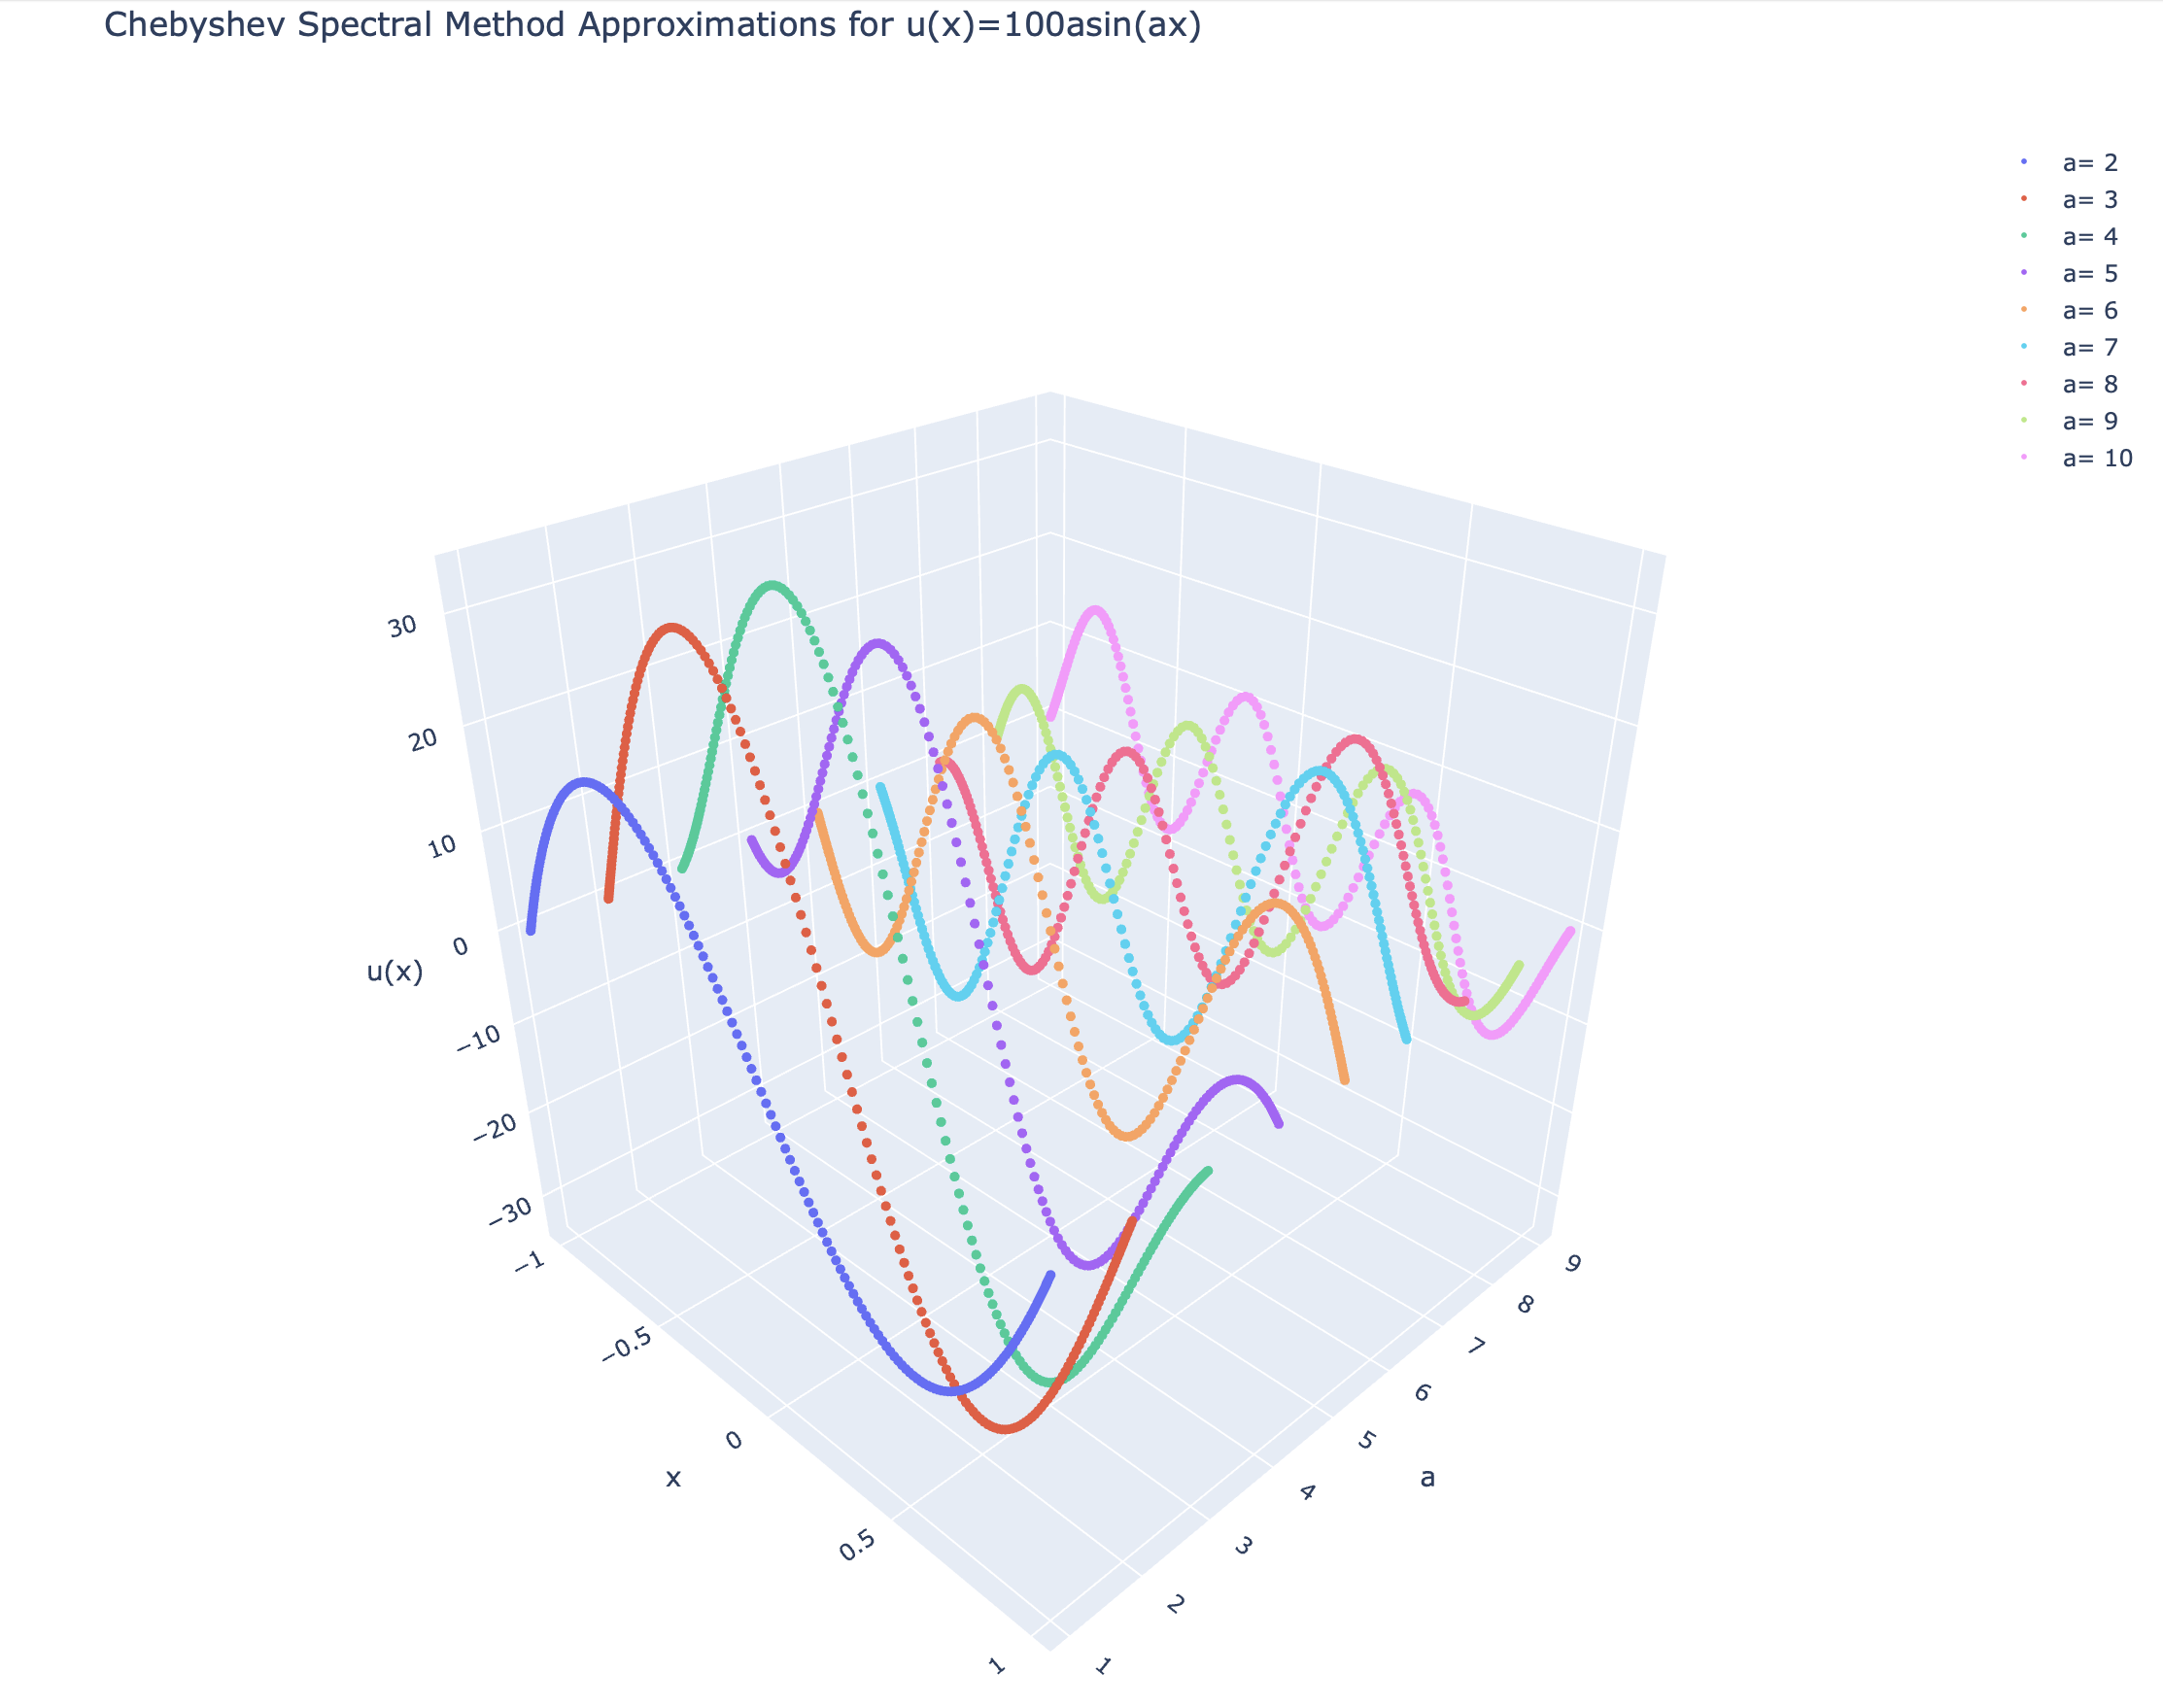

In [17]:
# graph the Chebyshev method 
# initialize the problem 
a = -1
b = 1.0
u_a = 0.0
u_b = 0
N = 200

# define the functions for graphing 
functions = [lambda x, n=n: (n + 1) * 100 * numpy.sin((n + 1) * x) for n in range(10)]
    
# graph only the centered difference solutions 
traces = []
for i in range(1,10):
    x,U = cheb_poisson(N,functions[i])
    x_values = x
    y_values = my_list = [i for _ in range(len(x))]
    z_values = U
    traces.append(go.Scatter3d(
        x=x_values,
        y=y_values,
        z=z_values,
        mode='markers',
        marker=dict(
            size = 3
        ),
        name=f'a= {i+1}'
    ))

layout = go.Layout(
    title='Chebyshev Spectral Method Approximations for u''(x)=100asin(ax)',
    scene=dict(
        xaxis_title='x',
        yaxis_title='a',
        zaxis_title='u(x)',
        camera=dict(
            eye=dict(x=1.5, y=-1.5, z=1.25) 
        )
    ),
    height=1000,
    width=None 
)

# set the responsive attribute
config = {
    'responsive': True
}
fig = go.Figure(data=traces, layout=layout)
#fig.show()
display(Image(filename='Chebyshev_vs_Finite_Difference_pics/3.png'))

*Figure 3: The Chebyshev spectral method approximations to $u''(x)=100a\sin(ax)$ with various values of $a$.*

**Analysis of figure 3:** This is an interactive plot displaying the Chebyshev spectral method approximations to $u"(x)=100a\sin(ax)$ with various values of $a$. The $x$-axis represents the grid points in $[-1,1]$, the $a$-axis represents the various values of $a$, and the $u(x)$-axis represents the solution space. The colored orbs represent the approximate solutions. The orbs near $x=0$ are spaced further apart compared to orbs near $x=1$ and $x=-1$ because the $202$ mesh points are not equidistant. 


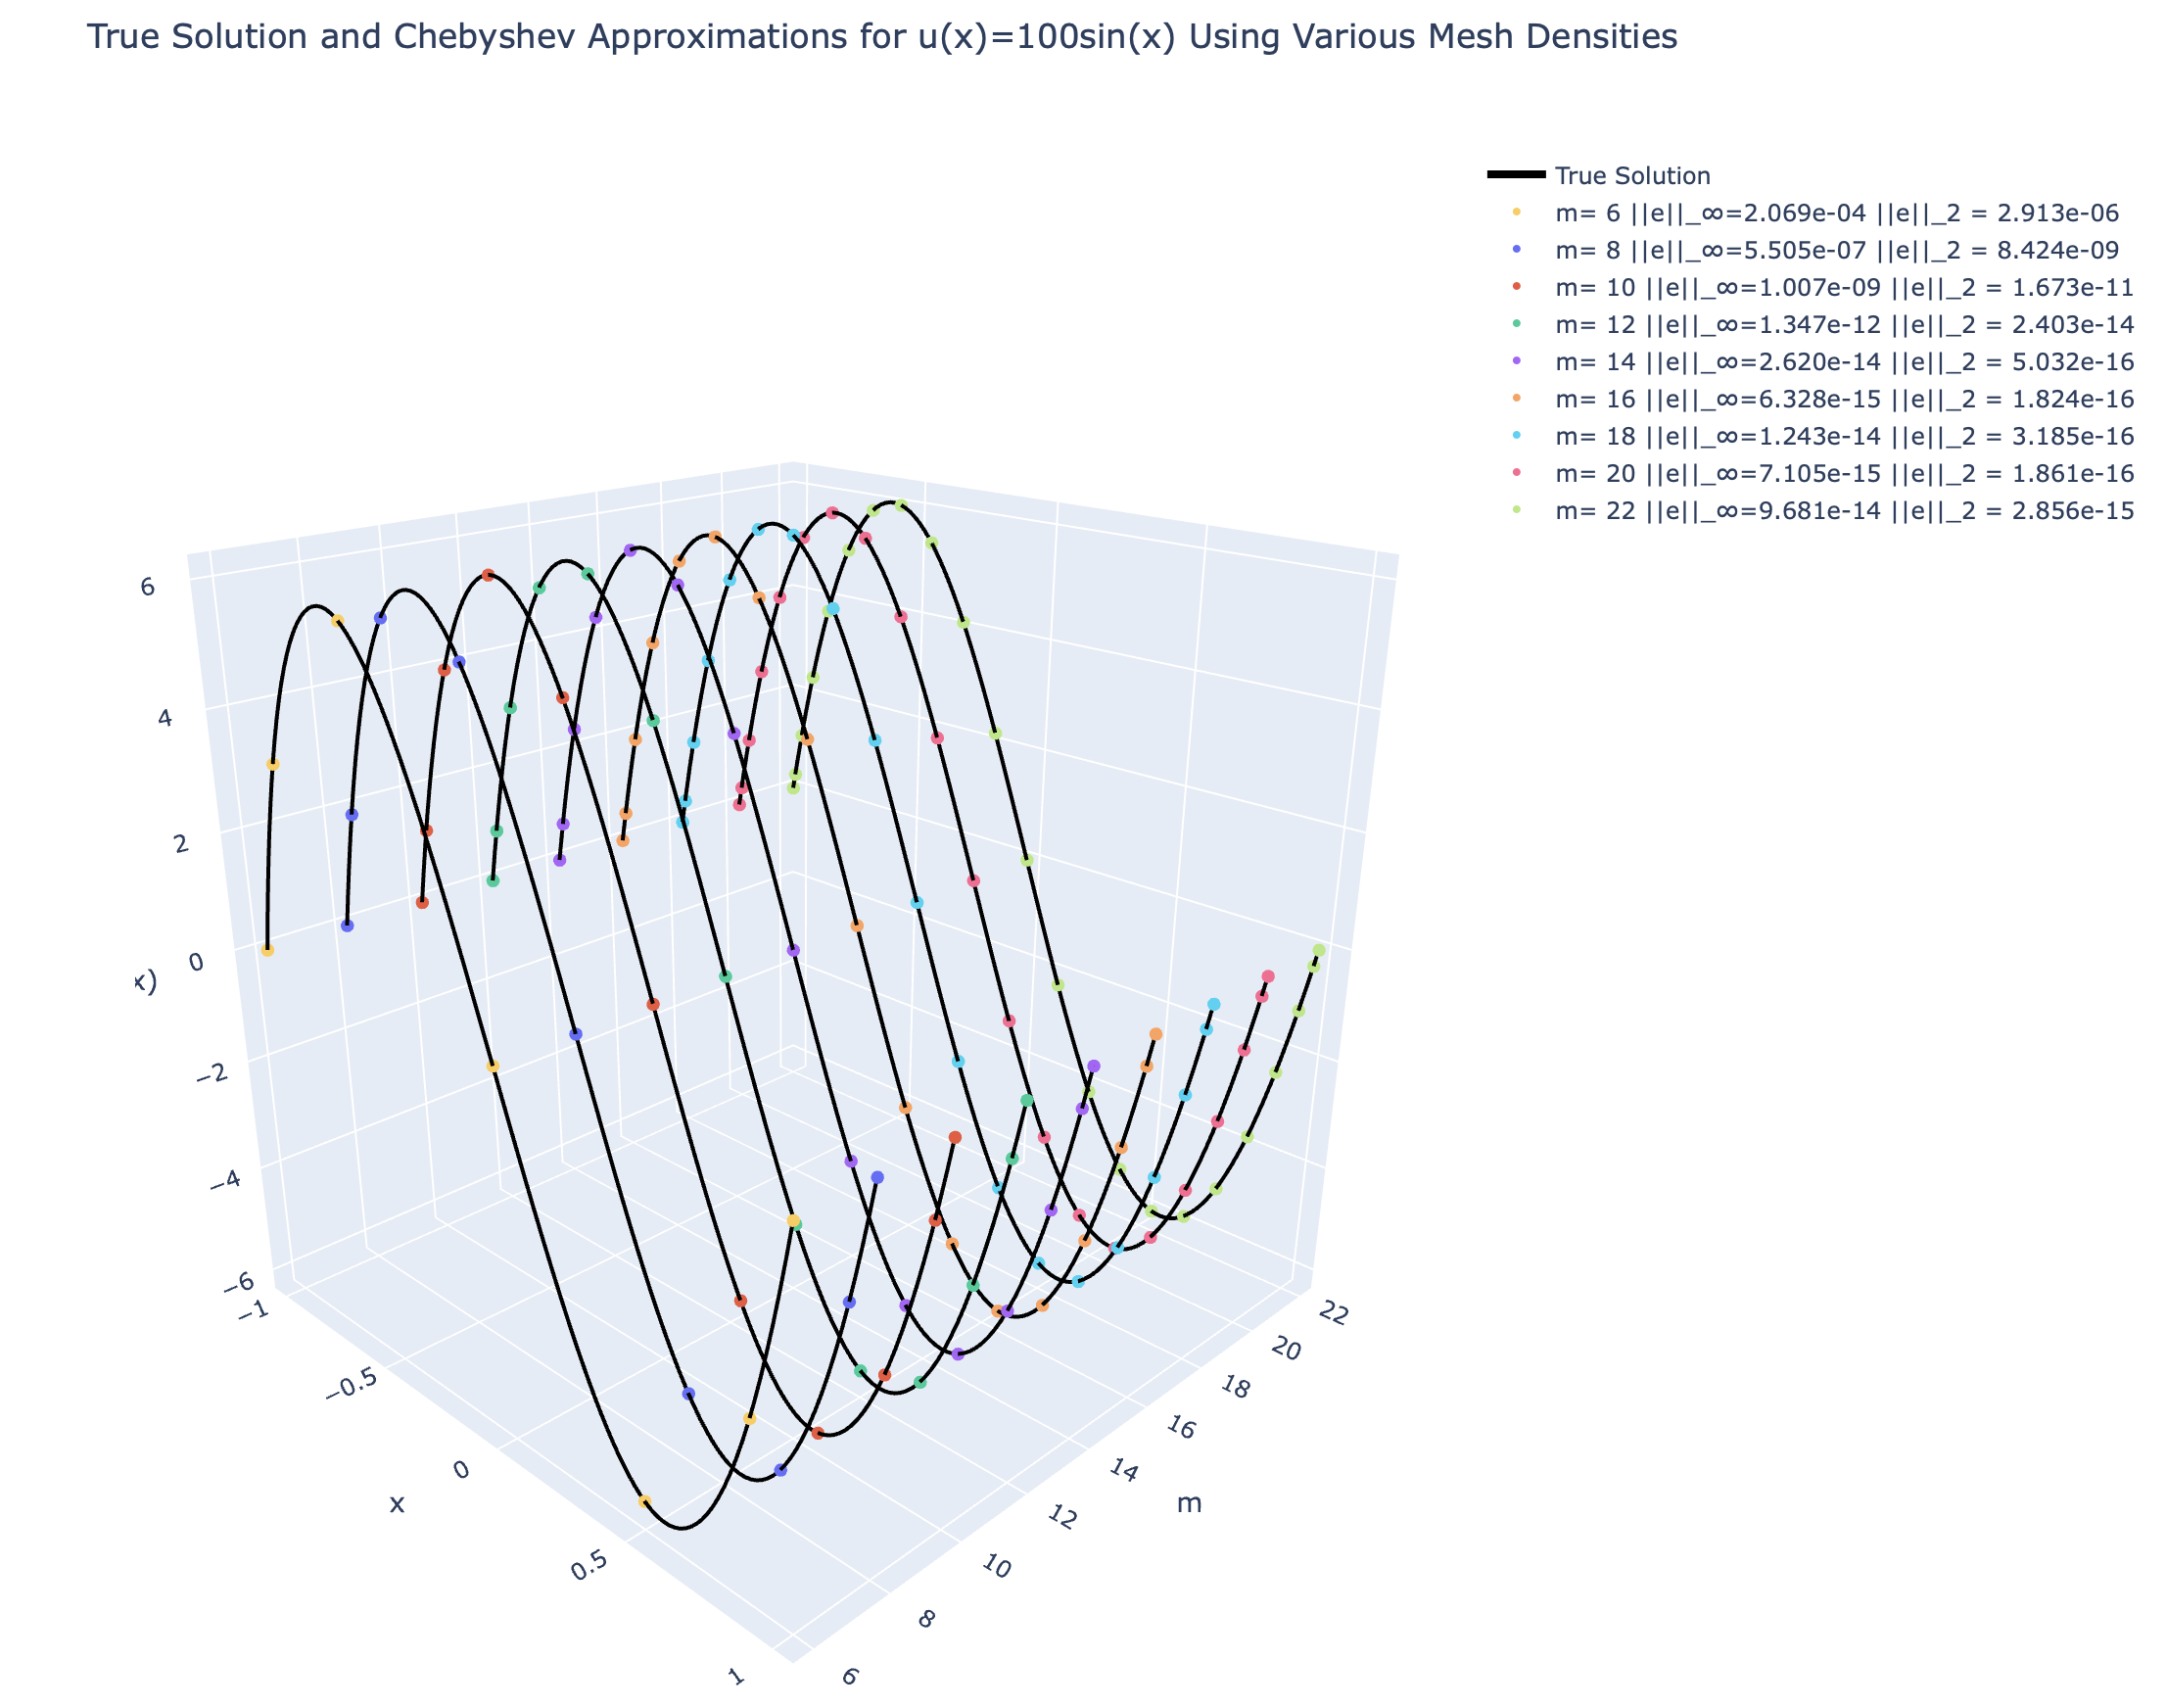

In [18]:
# choose the same function for convergence analysis
f = lambda x: 100 * numpy.sin(x)

# define the list of mesh points for Chebyshev
m = [2 * n for n in range(2, 20)]

# compute the global and infinity norm errors
error = []
error2 = []
for i in m:
    x, U = cheb_poisson(i,f)
    u = u_true(x)
    u = u.astype(float)
    error.append(numpy.linalg.norm(U - u, ord=numpy.infty))
    
    # compute the global error
    delta_x = x_bc[1] - x_bc[0]
    error2.append(delta_x * numpy.linalg.norm(U - u, ord=2))
    
# graph the approximate and true solutions with the errors. 

# the true solutions
traces = []
for i in range(1,10):
    x_bc = numpy.linspace(a, b, 100 + 2)
    x_values = x_bc
    y_values = my_list = [(i+2)*2 for _ in range(len(x_bc))]
    z_values = u_true(x_bc)
    trace_name = 'True Solution' if i == 1 else ''
    show_legend = True if i == 1 else False
    traces.append(go.Scatter3d(
        x=x_values,
        y=y_values,
        z=z_values,
        mode='lines',
        line=dict(
            width=4,
            color = 'black' 
        ),
        name=trace_name,
        showlegend=show_legend
    ))
    
# the approximate solutions 
for i in range(1,10):
    x,U = cheb_poisson(m[i],f)
    x_values = x
    y_values = my_list = [(i+2)*2 for _ in range(len(x_bc))]
    z_values = U
    traces.append(go.Scatter3d(
        x=x_values,
        y=y_values,
        z=z_values,
        mode='markers',
        marker=dict(
            size = 4
        ),
        name=f'm= {m[i]} ||e||_∞={"{:.3e}".format(error[i])} ||e||_2 = {"{:.3e}".format(error2[i])}'
    ))

# create the layout
layout = go.Layout(
    title='True Solution and Chebyshev Approximations for u''(x)=100sin(x) Using Various Mesh Densities',
    scene=dict(
        xaxis_title='x',
        yaxis_title='m',
        zaxis_title='u(x)',
        camera=dict(
            eye=dict(x=2.2, y=-2.2, z=1.3) 
        )
    ),
    height=1000,
    width=None 
)

# set the responsive attribute
config = {
    'responsive': True
}
# create the figure and plot it
fig = go.Figure(data=traces, layout=layout)
#fig.show()
display(Image(filename='Chebyshev_vs_Finite_Difference_pics/4.png'))

*Figure 4: Chebyshev spectral method approximations to $u''(x)=100\sin(x)$ with various $m$.*

**Analysis of figure 4:** This is an interactive plot displaying the Chebyshev approximations to $u"(x)=100\sin(x)$ with various node counts. The $x$-axis represents the grid points in $[-1,1]$, the $m$-axis represents the node counts, and the $u(x)$-axis represents the solution space. The colored orbs represent the approximate solutions and the black lines represent the true solution. The Chebyshev method requires a small number of nodes to reach a high degree of accuracy. The method is so accurate that machine errors become significant for higher values of $m$. 

<br><br>

### **Comparison of the Convergence Behaviors, Based on Mesh Size**

The global and infinity-norm errors for both methods are plotted on log-log graphs for various values of $\Delta x=\frac{1}{m+1}$.

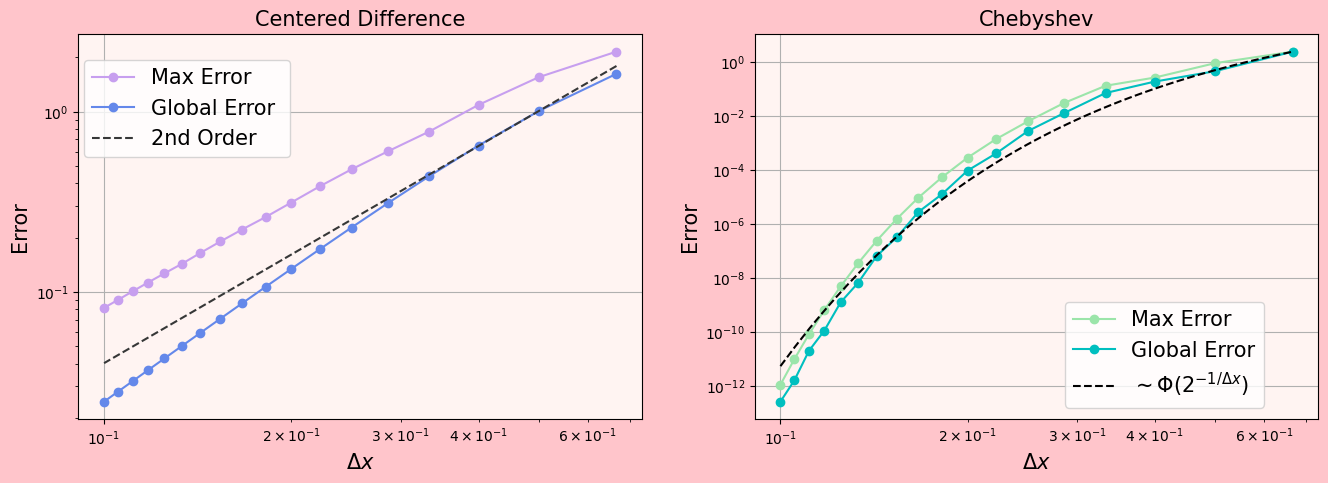

In [19]:
# analyze the convergence behaviors of both methods #####

# initialize
a = -1
b = 1.0
u_a = 0.0
u_b = 0

# choose a function to use for numerical convergence analysis
f = lambda x: numpy.exp(5*x)
u_true1 = lambda x: (numpy.exp(5.0 * x) - x * numpy.sinh(5.0) - numpy.cosh(5.0)) / 25.0

# define the number of mesh points
num_steps = [n for n in range(2, 20)]

# initialize arrays
error_finite_i = numpy.empty(len(num_steps))
error_finite_g = numpy.empty(len(num_steps))
error_cheb_i = numpy.empty(len(num_steps))
error_cheb_g = numpy.empty(len(num_steps))
delta_x = numpy.empty(len(num_steps))

for (i, N) in enumerate(num_steps):
    m = N
    # compute the finite difference infinity norm errors
    U = centered_difference(a,b,m,f)
    x_bc = numpy.linspace(-1,1,m+2)
    error_finite_i[i] = numpy.linalg.norm(U - u_true1(x_bc), ord=numpy.infty)
    
    # compute the finite difference global errors
    delta_x[i] = x_bc[1] - x_bc[0]
    error_finite_g[i] = delta_x[i] * numpy.linalg.norm(U - u_true1(x_bc), ord=2)
    
    # compute the chebyshev infinity norm errors
    x, U = cheb_poisson(N,f)
    error_cheb_i[i] = numpy.linalg.norm(U - u_true1(x), ord = numpy.infty)

    # compute the chebychev global error by looping through the N spaces between the Chebyshev nodes
    er = []
    for j in range(N):
        delta_x_temp = x[j+1] - x[j]
        e = numpy.abs(u_true1(x[j+1]) - U[j+1])
        e = delta_x_temp * e
        er.append(e)
    error_cheb_g[i] = float(numpy.linalg.norm(er))

# plot error vs. delta_t
fig = plt.figure(figsize= (8,5))
fig.set_figwidth(fig.get_figwidth() * 2)
fig.patch.set_facecolor('xkcd:light rose')
axes = fig.add_subplot(1, 2, 1)
axes.loglog(delta_x, error_finite_i, marker ='o', color = 'xkcd:lavender', label='Max Error ')
axes.loglog(delta_x, error_finite_g, marker ='o', color = 'xkcd:soft blue', label='Global Error ')
order_C = lambda delta_x, error_finite_g, order: numpy.exp(numpy.log(error_finite_g) - order * numpy.log(delta_x))
axes.loglog(delta_x, order_C(delta_x[1], error_finite_g[1], 2.0) * delta_x**2.0, '--', color ='xkcd:dark grey', label="2nd Order")
axes.legend(loc=(.01,.68), fontsize = 15)
axes.grid(True)
axes.set_title("Centered Difference", fontsize = 15)
axes.set_xlabel("$\Delta x$", fontsize = 15)
axes.set_ylabel("Error", fontsize = 15)
axes.set_facecolor('xkcd:very light pink')
axes = fig.add_subplot(1, 2, 2)

# define the exponential function
def exponential_func(x, a, b):
    return a * numpy.exp(b * (1/x))

# fit the data to the exponential function
params, covariance = curve_fit(exponential_func, delta_x, error_cheb_g)

# extract the parameters
a, b = params

# generate x values for plotting the fitted curve
x_fit = numpy.linspace(min(delta_x), max(delta_x), 100)
y_fit = exponential_func(x_fit, a, b)


axes.loglog(delta_x, error_cheb_i, marker ='o', color = 'xkcd:hospital green', label='Max Error')
axes.loglog(delta_x, error_cheb_g, marker ='o', color = 'c', label='Global Error')
axes.loglog(x_fit, y_fit, 'k--', label = '$\sim \Phi(2^{-1/ \Delta x})$')
axes.grid(True)
axes.legend(loc=(.55,.03), fontsize = 15)
axes.set_title("Chebyshev" , fontsize = 15)
axes.set_xlabel("$\Delta x$", fontsize = 15)
axes.set_ylabel("Error", fontsize = 15)
axes.set_facecolor('xkcd:very light pink')
plt.show()

*Figure 5: The $||e||_\infty$ and $||e||_2$ errors on log-log graphs for various values of $\Delta x$.*

**Analysis of figure 5:** 
* **(a):** The centered difference method demonstrates convergence behavior that scales as $O(\Delta x^2)$, indicating it is second-order accurate.
* **(b):** The Chebyshev spectral method displays errors that decrease exponentially with $\Delta x$, indicating it has spectral accuracy. 



<br><br>

## **Convergence Analysis for the Finite Difference Method**

The algebraic equations are an approximation to the original boundary value problem, and so the true solution will not exactly satisfy these equations, the difference between the $U_i$ and $u(x_i)$ is called the local truncation error $\tau$.

For our centered finite difference approximation, we have

$$\frac{1}{\Delta x^2} (U_{i+1} - 2 U_i + U_{i-1}) = f(x_i).$$

Replacing $U_i$ with $u(x_i)$ in this equation leads to

$$\tau_i = \frac{1}{\Delta x^2} (u(x_{i+1}) - 2 u(x_i) + u(x_{i-1})) - f(x_i).$$

We assume $u(x)$ is smoooth, and replace the $u(x_i)$ with their Taylor series counterparts. 

The relevant Taylor series are 

$$u(x_{i \pm 1}) = u(x_i) \pm u'(x_i) \Delta x + \frac{1}{2} u''(x_i) \Delta x^2 \pm \frac{1}{6} u'''(x_i) \Delta x^3 + \frac{1}{24} u^{(4)}(x_i) \Delta x^4 + \mathcal{O}(\Delta x^5)$$

which leads to an expression for the local truncation error, $\tau_i$ of 

$$\begin{aligned}
    \tau_i &= \frac{1}{\Delta x^2} \left [u''(x_i) \Delta x^2 + \frac{1}{12} u^{(4)}(x_i) \Delta x^4 + \mathcal{O}(\Delta x^5) \right ] - f(x_i) \\
    &= u''(x_i) + \frac{1}{12} u^{(4)}(x_i) \Delta x^2 + \mathcal{O}(\Delta x^4) - f(x_i) \\
    &= \frac{1}{12} u^{(4)}(x_i) \Delta x^2 + \mathcal{O}(\Delta x^4),
\end{aligned}$$

which indicates the method is 2nd order accurate. And as long as $u^{(4)}(x_i)$ remains finite (smooth), we know that $\tau_i\rightarrow 0$ as $\Delta x\rightarrow 0$. And so the convergence depends on $\Delta x$. These results match well with the numerical results found in the previous part, because we found in both cases that this method is 2nd order accurate in space.

<br><br>
## **Convergence Analysis for the Chebyshev Spectral Method**

One way to analyze the accuracy of the Chebyshev spectral method is to gauge the Chebyshev nodes' optimality as a set of interpolation points. Consider the Lebesgue function

$$\lambda_N(x)  = \sum_{i=0}^N\big{|}\ell_i(x)\big{|}$$

Where $\ell_i(x)$ are Lagrange basis functions for a given set of $x_i$. the maximum of the Lebesque function is called $\Lambda_n$, the Lebesque constant and are clearly related to Lagrangian interpolation as they provde a first estimate for the interpolation error. Unfortunately, $\Lambda_N$ is not uniformly bounded regardless of the nodes used as one can show that 

$$\Lambda_N > \mathcal{O}(\log N) \quad \text{as} \quad N \rightarrow \infty$$

To actually show that the Chebyshev nodes are optimal consider the monic polynomial $p(z)$  in the complex plane of degree $N$

$$p(z) = \prod^N_{k=1} (z - z_k)$$

where $z_k$ are the roots with possible non-trivial multiplicity. Manipulating this a bit we can also write the related expressions

$$\begin{aligned}
    |p(z)| &= \prod^N_{k=1} |z - z_k| \\
    \log|p(z)| &= \sum^N_{k=1} \log|z - z_k|.
\end{aligned}$$

Let 

$$\phi_N(z) = \frac{1}{N} \sum^N_{k=1} \log |z - z_k|,$$

since $\phi_N(z)$ is harmonic it satisfies Laplace's equation in the complex plane except at the roots $z_k$. This setup can be viewed as an electrostatic potential with charges at the roots $z_k$. The potential from each of the charges is

$$\frac{\log |z - z_k|}{N}.$$.

Consider now the relationship between $|p(z)|$ and $\phi_N(z)$. From our previous expressions we know that

$$|p(z)| = e^{N \phi_N(z)}.$$

If $\phi_N(z)$ is roughly constant on the interval $[-1,1]$ then $|p(z)|$ is as well. If on the other hand $\phi_N(z)$ varies then the variation of $|p(z)|$ will be exponential, especially with large $N!$, With an eye towards this behavior consider the $N\rightarrow \infty$ limit and consider the points $x_j$ distributed in $[-1,1]$ according to a density function $p(x)$ with

$$\int^1_{-1} \rho(x) dx = 1.$$


From this density function we also know the number of grid points in an interval $[a,b]$ as

$$1 = N \int^b_a \rho(x) dx.$$

Using this framework we can write the potential as

$$\phi(z) = \int^1_{-1} \rho(x) \log |z - x| dx.$$

In the limit $N\rightarrow \infty$ we can show for equispaced points that

$$\phi(z) = -1 +\frac{1}{2} \Re((z + 1) \log(z + 1) - (z-1)\log(z-1)).$$

Note that $\phi(0)=-1$ and $\phi(\pm 1)=-1+\log 2$ which implies that if a polynomial $p$ has equispaced roots on $[-1,1]$ then it will take values that are $2^N$ larger near the points $\pm 1$ than near $0$.

Instead if we consider the distribution for the Chebyshev points

$$\rho(x) = \frac{1}{\pi \sqrt{1 - x^2}}, \quad x\in[-1,1]$$

we can show that the resulting potential is

$$\phi(z) = \log\frac{\left|z - \sqrt{z^2 - 1} \right |}{2}.$$

Interestingly these formula have a simple interpretation, the level curves of $\phi(z)$ are the ellipses with foci $\pm 1$. The value of $\phi(z)$ along any such ellipse is the logarithm of half the sum of the semimajor and minor axes of the ellipses. The degenerate ellipse $[-1,1]$ is a level curve as well and takes on the constant value $-\log 2$. This turns out to be optimal with the polynomial growing as

$$|p(z)| = e^{N \phi(x)} \approx 2^{-N}, ~~~ x\in[-1,1].$$

And so to summarize, the Chebyshev spectral method relies on interpolating $u(x)$ using Chebyshev polynomials at the unevenly spaced nodes, called Chebyshev roots, and the error decreases exponentially with increasing $N$ (or decreasing $\Delta x$.  This matches our previous results well, because we found numerically that the spectral method's error decreases exponentially with decreasing $\Delta x$.


<br><br>

### **Computation Times as Functions of Mesh Densities**

The computation times for both methods are plotted as functions of mesh densities. 

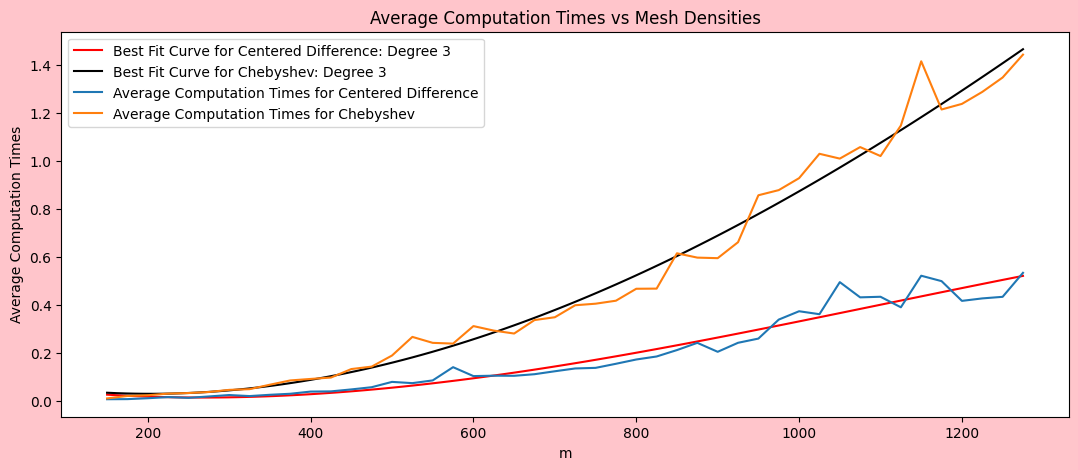

In [20]:
# plot the computation times as functions of m.
# initialize
f = lambda x: 100* numpy.sin(x)
a=-1
b=1

# compare the computation times for various values of m. 
m = list(numpy.arange(100, 1300, 25))
centered_times = []
chebyshev_times = []
for i in m:
    
    def wrapper():
        centered_difference(a, b, i, f)
    def wrapper1():
        cheb_poisson(i,f)
        
    elapsed_time = timeit.timeit(wrapper, number=20)
    centered_times.append(elapsed_time)
    
    elapsed_time = timeit.timeit(wrapper1, number=20)
    chebyshev_times.append(elapsed_time)


fig = plt.figure(figsize= (13,5))

# fit a polynomial regression of degree 2 for centered difference
degree = 3
coefficients = numpy.polyfit(m[2:], centered_times[2:], degree)
polynomial_of_best_fit = numpy.poly1d(coefficients)

# generate x values for plotting the polynomial curve
x_fit = numpy.linspace(min(m[2:]), max(m[2:]), 100)
y_fit = polynomial_of_best_fit(x_fit)
plt.plot(x_fit, y_fit, color='red', label='Best Fit Curve for Centered Difference: Degree {}'.format(degree))

# fit a polynomial regression of degree 2 for chebyshev 
coefficients = numpy.polyfit(m[2:], chebyshev_times[2:], degree)
polynomial_of_best_fit = numpy.poly1d(coefficients)

# generate x values for plotting the polynomial curve
x_fit = numpy.linspace(min(m[2:]), max(m[2:]), 100)
y_fit = polynomial_of_best_fit(x_fit)
plt.plot(x_fit, y_fit, color='black', label='Best Fit Curve for Chebyshev: Degree {}'.format(degree))



fig.patch.set_facecolor('xkcd:light rose')
plt.plot(m[2:],  centered_times[2:], label='Average Computation Times for Centered Difference')
plt.plot(m[2:],  chebyshev_times[2:], label='Average Computation Times for Chebyshev')
plt.xlabel('m')
plt.ylabel('Average Computation Times')
plt.title(f"Average Computation Times vs Mesh Densities")
plt.legend()
plt.show()

*Figure 6: Average computation times of centered difference and Chebyshev as functions of mesh densities*


**Analysis of figure 6:** We have the average (over 20 trials) computation times for both methods as functions of $m$. Generally, Chebyshev has higher computation times than the Centered Difference method due to its complexity. The lines are not smooth because computation times can be inconsistent in practice. In a purely theoretical study, the lines would be smooth. However, in practice, computation times can vary due to factors like system load, resource contention, and background processes. The best fit curves indicate time complexities of $O(m^3)$ for both methods, in practice. This is likely because the time complexity of numpy.linalg.solve() for an $m \times m$ matrix is $O(m^3)$. 

<br><br>

### **Computation Times as Functions of Desired Accuracies.**

The computation times of both methods are plotted as functions of desired accuracies. 

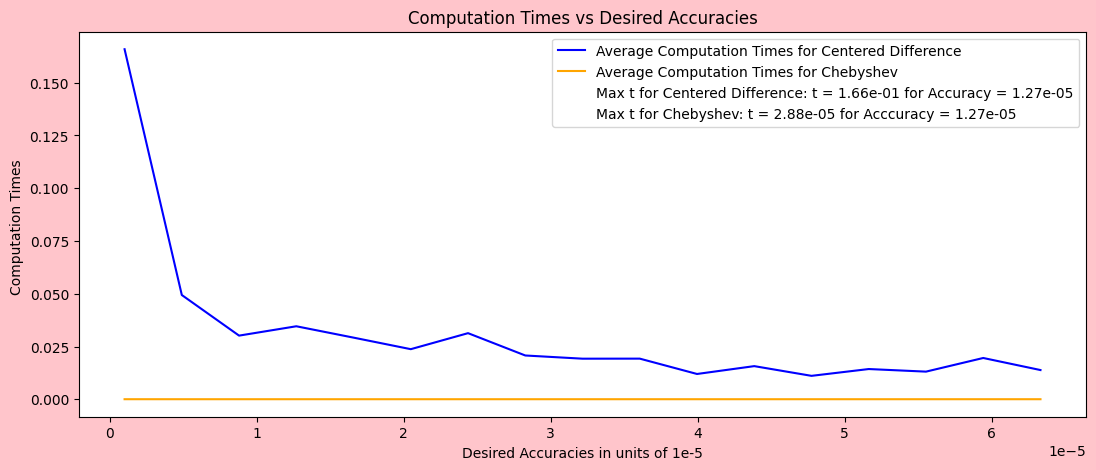

In [21]:
# plot computation times vs accuracies 
# initialize
f = lambda x: 100 * numpy.sin(x)
a=-1
b=1
centered_times = []
chebyshev_times = []

# define a wrapper function for the timeit function
def wrapper():
        centered_difference(a, b, m, f)

# compute times for centered difference
accuracies = numpy.linspace(7.5e-5,1e-6,20)
for i in accuracies:
    accuracy = 1
    m = 50
    while accuracy > i:
        # start_time = time.time()
        U = centered_difference(a,b,m,f)
        # end_time = time.time()

         # elapsed_time = end_time - start_time
        elapsed_time = timeit.timeit(wrapper, number=100)
       
        x_bc = numpy.linspace(a, b, m + 2)
        u = u_true(x_bc)
        u = u.astype(float)
        
        # compute the global error
        delta_x = x_bc[1] - x_bc[0]
        accuracy = delta_x * numpy.linalg.norm(U - u, ord=2)
        m += 5
        if accuracy <= i:
            centered_times.append(elapsed_time)
            break

# compute times for Chebyshev
for i in accuracies:
    accuracy = 1
    m = 5
    while accuracy > i:
        start_time = time.time()
        x, U = cheb_poisson(m,f)
        end_time = time.time()
        elapsed_time = end_time - start_time
        u = u_true(x)
        u = u.astype(float)

        # compute the global error by looping through the N spaces between the Chebyshev nodes
        er=[]
        for j in range(m):
            delta_x = x[j+1] - x[j]
            e = numpy.abs(u_true(x[j+1]) - U[j+1])
            e = delta_x * e
            er.append(e)
        accuracy = float(numpy.linalg.norm(er))
        
        m += 1
        if accuracy <= i:
            chebyshev_times.append(elapsed_time)
            break

# compute max values and plot 
max_cent = max(centered_times[3:])
max_cheb = max(chebyshev_times[3:])
index_cent = numpy.argmax(centered_times[3:])
index_cheb = numpy.argmax(chebyshev_times[3:])

fig = plt.figure(figsize= (13,5))
fig.patch.set_facecolor('xkcd:light rose')
plt.plot(accuracies[3:],  centered_times[3:], color='blue', label='Average Computation Times for Centered Difference')
plt.plot(accuracies[3:], chebyshev_times[3:], color='orange', label='Average Computation Times for Chebyshev')
label1_text = f'Max t for Centered Difference: t = {max_cent:.2e} for Accuracy = {accuracies[index_cent]:.2e}'
plt.plot([], [], ' ', label=label1_text)
label2_text = f'Max t for Chebyshev: t = {max_cheb:.2e} for Acccuracy = {accuracies[index_cheb]:.2e}'
plt.plot([], [], ' ', label=label2_text)
plt.xlabel('Desired Accuracies in units of 1e-5')
plt.ylabel('Computation Times ')
plt.title(f"Computation Times vs Desired Accuracies")
plt.legend()
plt.show()

*Figure 7: Average computation times for centered difference and Chebyshev as functions of desired accuracy.*

**Analysis of figure 7:** We have the average (over 100 trials) computation times of centered difference and Chebyshev for desired accuracies between $.00001$ and $.000065$. For the specified range of desired accuracies, Chebyshev computes practically in no time because only a few nodes are needed to achieve the accuracies. The average computation times for Centered Difference are significantly higher due to the large values of $m$ being required to achieve the desired accuracies. These results indicate that the Chebyshev spectral method is superior when accuracy is desired. Please note the graphs slightly fluctuate because computation times are inconsistent in practice.

## **References** 

[1] Arieh Iserles (2008). A first course in the numerical analysis of differential equations. Cambridge University Press. p. 23. ISBN 9780521734905.

[2] Christian Grossmann; Hans-G. Roos; Martin Stynes (2007). Numerical Treatment of Partial Differential Equations. Springer Science & Business Media. p. 23. ISBN 978-3-540-71584-9.

[3] "Chebyshev interpolation: An interactive tour". Mathematical Association of America (MAA) – includes illustrative Java applet.

[4] Grant, I. S.; Phillips, W. R. (2008). Electromagnetism. Manchester Physics (2nd ed.). John Wiley & Sons. ISBN 978-0-471-92712-9.

[5] Gottlieb, David; Orszag, Steven A. (1989). Numerical analysis of spectral methods: theory and applications (5. print. ed.). Philadelphia, Pa.: Society for Industrial and Applied Mathematics. ISBN 978-0898710236.

[6] K.W. Morton and D.F. Mayers, Numerical Solution of Partial Differential Equations, An Introduction. Cambridge University Press, 2005.

[7] Mathews, John H. (2003). "Module for Chebyshev polynomials". Department of Mathematics. Course notes for Math 340 Numerical Analysis & Math 440 Advanced Numerical Analysis. Fullerton, CA: California State University. Archived from the original on 29 May 2007. Retrieved 6 May 2023.

[8] Mandli, K. T. (n.d.). Boundary Value Problems. Retrieved from https://github.com/mandli/numerical-methods-pdes/blob/master/04_BVP_problems.ipynb

[9] Mandli, K. T. (n.d.). Spectral Methods. Retrieved from https://github.com/mandli/numerical-methods-pdes/blob/master/14_spectral.ipynb

[10] Peter Olver (2013). Introduction to Partial Differential Equations. Springer. Chapter 5: Finite differences. ISBN 978-3-319-02099-0.

[11] "Poisson equation", Encyclopedia of Mathematics, EMS Press, 2001 [1994]

[12] Poisson Equation at EqWorld: The World of Mathematical Equations

[13] Smith GD (1985). Numerical solution of partial differential equations: finite difference methods (3rd ed.). Oxford University Press.
